# Incremental control example
Åström & Wittenmark Problem 5.3

We have plant model
$$ H(z) = \frac{z+0.7}{z^2 - 1.8z + 0.81} $$
and controller
$$ F_b(z) = \frac{s_0z^2 + s_1z + s_2}{(z-1)(z + r_1)} $$
Want closed-loop characteristic polynomial $A_c(z) = z^2 - 1.5z + 0.7$ and observer poles in the range $0<\alpha<a$.
### Diophantine equation
$$  (z^2 - 1.8z + 0.81)(z-1)(z+r_1) + (z+0.7)(s_0z^2 + s_1z + s_2) = (z-\alpha)^2(z^2-1.5z+0.7) $$
\begin{align}
(z^2 - 1.8z + 0.81)(z^2 +(r_1-1)z - r_1) + s_0z^3 + s_1z^2 + s_2z + 0.7s_0z^2 + 0.7s_1z + 0.7s_2 &= \\ \qquad\qquad\qquad\qquad\qquad\qquad (z^2 -2\alpha z + \alpha^2)(z^2 - 1.5z + 0.7)\\
(z^4 - 1.8z^3 + 0.81z^2 + (r_1-1)z^3 - 1.8(r_1-1)z^2 + 0.81(r_1-1)z - r_1z^2 + 1.8r_1z - 0.81r_1 + \\
\qquad\qquad\qquad s_0z^3 + s_1z^2 + s_2z + 0.7s_0z^2 + 0.7s_1z + 0.7s_2 = \\
\qquad\qquad\qquad\qquad\qquad\qquad z^4 - 2\alpha z^3 + \alpha^2 z^2 -1.5z^3 + 3\alpha z^2 - 1.5\alpha^2 z + 0.7z^2 - 1.4\alpha z + 0.7\alpha^2
\end{align}

Resulting equations when setting coefficients equal
\begin{align}
\begin{cases} z^3: & r_1 + s_0 = 1.8 + 1 -1.5 -2\alpha\\
              z^2: & -2.8 r_1 + 0.7s_0 + s_1 = -0.81 -1.8 +0.7 + \alpha^2 + 3\alpha\\
              z^1: &  2.61r_1 + 0.7s_1 + s_2 = 0.81 -1.5\alpha^2 - 1.4\alpha\\
              z^0: & -0.81r_1 + 0.7s_2 = 0.7\alpha^2  \end{cases}
\end{align}

### Feedforward part of controller
$$T(z) = t_0A_o(z) = t_0(z-\alpha)^2$$
$$ G_c(z) = \frac{T(z)B(z)}{A_o(z)A_c(z)} = \frac{t_0 B(z)}{A_c(z)}, \quad \text{want}\, G_c(1)=1$$
$$t_0 = \frac{A_c(1)}{B(1)} = \frac{1 - 1.5+0.7}{1+0.7} = \frac{2}{17}$$

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sy
import control.matlab as cm
import ipywidgets as widgets
%matplotlib widget

## Symbolic solution

In [2]:
sy.init_printing()
alphaa, hh, r1, s0, s1,s2 = sy.symbols('alpha, h, r1, s0, s1,s2', 
                                        real=True)
zz = sy.symbols('z', real=False)

In [3]:
A = zz**2 - 1.8*zz + 0.81
B = zz+0.7
R = (zz-1)*(zz+r1)
S = s0*zz**2 + s1*zz + s2
LHS = sy.Poly(A*R + B*S, zz)
LHS

In [4]:
RHS = sy.Poly((zz-alphaa)**2*(zz**2 - 1.5*zz + 0.7), zz)
Dioph = LHS-RHS
coeffs = Dioph.all_coeffs()
coeffs

In [5]:
sol=sy.solve(coeffs, [r1,s0, s1,s2]);

## Effect of observer pole

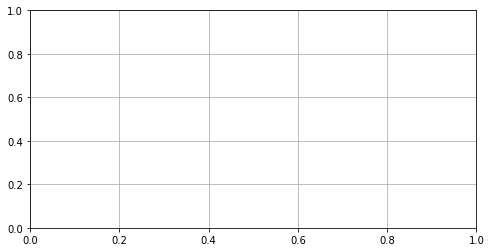

interactive(children=(FloatSlider(value=0.4, description='alpha', max=0.9, step=0.02), Output()), _dom_classes…

In [6]:
h = 1
# The plant
H = cm.tf([1, 0.7], [1, -1.8, 0.81], h)


# set up plot
fig, ax = plt.subplots(figsize=(8, 4))
#ax.set_ylim([-.1, 4])
ax.grid(True)

def bode_S_T_and_Gc(alpha):
    """
    Returns the bode plot data for S and T given observer pole
    """
    r1n = float(sol[r1].subs({alphaa: alpha}))
    s0n = float(sol[s0].subs({alphaa: alpha}))
    s1n = float(sol[s1].subs({alphaa: alpha}))
    s2n = float(sol[s2].subs({alphaa: alpha}))
    
    B = [1, 0.7]
    Ac = [1, -1.5, 0.7]
    Rp = np.convolve([1, r1n],[1,-1])
    Fb = cm.tf([s0n, s1n, s2n], Rp , h)
    Ff = np.sum(Ac)/np.sum(B) * cm.tf(np.convolve([1, -alpha], [1, -alpha]), Rp, h)
                    
    #Gc = cm.minreal(Ff * cm.feedback(H, Fb))
    Gc = Ff * cm.feedback(H, Fb)
    Ss = cm.feedback(1, H*Fb)
    Ts = cm.feedback(H*Fb, 1)

    Gcbode = cm.bode(Gc, omega_limits=[0.01, 3], Plot=False)
    Sbode = cm.bode(Ss, omega_limits=[0.01, 3], Plot=False)
    Tbode = cm.bode(Ts, omega_limits=[0.01,3], Plot=False)
    
    return (Sbode, Tbode, Gcbode)
    

@widgets.interact(alpha=(0, 0.9, 0.02))
def update(alpha = 0.4):
    """Remove old lines from plot and plot new one"""
    [l.remove() for l in ax.lines]
    [l.remove() for l in ax.lines]
    Sb, Tb, Gb = bode_S_T_and_Gc(alpha)
    sh = ax.loglog(Sb[2], Sb[0], color='C0', label='Ss')
    th = ax.loglog(Tb[2], Tb[0], color='C1', label='Ts')
    gh = ax.loglog(Gb[2], Gb[0], color='C2', label='Gc')
    ax.legend(loc='lower center')
    

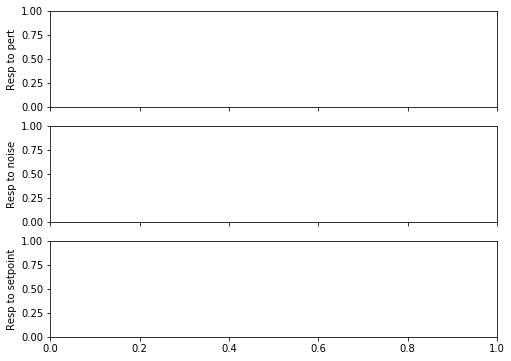

interactive(children=(FloatSlider(value=0.4, description='alpha', max=0.9, step=0.02), Output()), _dom_classes…

In [7]:
h = 1
# The plant
H = cm.tf([1, 0.7], [1, -1.8, 0.81], h)


# set up plot
fig, ax = plt.subplots(3,1,figsize=(8, 6), sharex=True )
ax[0].set_ylabel('Resp to pert')
ax[1].set_ylabel('Resp to noise')
ax[2].set_ylabel('Resp to setpoint')
def step_S_T_and_Gc(alpha):
    """
    Returns the bode plot data for S and T given observer pole
    """
    r1n = float(sol[r1].subs({alphaa: alpha}))
    s0n = float(sol[s0].subs({alphaa: alpha}))
    s1n = float(sol[s1].subs({alphaa: alpha}))
    s2n = float(sol[s2].subs({alphaa: alpha}))
    
    B = [1, 0.7]
    Ac = [1, -1.5, 0.7]
    Rp = np.convolve([1, r1n],[1,-1])
    Fb = cm.tf([s0n, s1n, s2n], Rp , h)
    Ff = np.sum(Ac)/np.sum(B) * cm.tf(np.convolve([1, -alpha], [1, -alpha]), Rp, h)
                    
    #Gc = cm.minreal(Ff * cm.feedback(H, Fb))
    Gc = Ff * cm.feedback(H, Fb)
    Ss = cm.feedback(1, H*Fb)
    Ts = cm.feedback(H*Fb, 1)

    NN = 50
    uu = np.ones(NN)
    uu[24:] = 0
    tt = np.arange(NN)
    Gcstep = cm.lsim(Gc, uu, tt)
    Sstep = cm.lsim(Ss, uu, tt)
    Tstep = cm.lsim(Ts, uu, tt)
    
    return (Sstep, Tstep, Gcstep)
    

@widgets.interact(alpha=(0, 0.9, 0.02))
def update(alpha = 0.4):
    """Remove old lines from plot and plot new one"""
    [[l.remove() for l in ax_.lines] for ax_ in ax]
    [[l.remove() for l in ax_.lines] for ax_ in ax]
    Sb, Tb, Gb = step_S_T_and_Gc(alpha)
    sh = ax[0].stem(Sb[1], Sb[0], markerfmt='C0o', label='Ss')
    th = ax[1].stem(Tb[0], markerfmt='C1o', label='Ts')
    gh = ax[2].stem(Gb[0], markerfmt='C2o', label='Gc')
    

In [ ]:
?plt.subplots

In [9]:
h = 1
# The plant
H = cm.tf([1, 0.7], [1, -1.8, 0.81], h)


# set up plot
fig, ax = plt.subplots(figsize=(8, 4))
#ax.set_ylim([-.1, 4])
ax.grid(True)

def bode_S_T_and_Gc(alpha):
    """
    Returns the bode plot data for S and T given observer pole
    """
    r1n = float(sol[r1].subs({alphaa: alpha}))
    s0n = float(sol[s0].subs({alphaa: alpha}))
    s1n = float(sol[s1].subs({alphaa: alpha}))
    s2n = float(sol[s2].subs({alphaa: alpha}))
    
    B = [1, 0.7]
    Ac = [1, -1.5, 0.7]
    Rp = np.convolve([1, r1n],[1,-1])
    Fb = cm.tf([s0n, s1n, s2n], Rp , h)
    Ff = np.sum(Ac)/np.sum(B) * cm.tf(np.convolve([1, -alpha], [1, -alpha]), Rp, h)
                    
    #Gc = cm.minreal(Ff * cm.feedback(H, Fb))
    Gc = Ff * cm.feedback(H, Fb)
    Ss = cm.feedback(1, H*Fb)
    Ts = cm.feedback(H*Fb, 1)

    Gcbode = cm.bode(Gc, omega_limits=[0.01, 3], Plot=False)
    Sbode = cm.bode(Ss, omega_limits=[0.01, 3], Plot=False)
    Tbode = cm.bode(Ts, omega_limits=[0.01,3], Plot=False)
    
    return (Sbode, Tbode, Gcbode)
    

@widgets.interact(alpha=(0, 0.9, 0.02))
def update(alpha = 0.4):
    """Remove old lines from plot and plot new one"""
    [l.remove() for l in ax.lines]
    [l.remove() for l in ax.lines]
    Sb, Tb, Gb = bode_S_T_and_Gc(alpha)
    sh = ax.semilogy(Sb[2], Sb[0], color='C0', label='Ss')
    th = ax.semilogy(Tb[2], Tb[0], color='C1', label='Ts')
    gh = ax.semilogy(Gb[2], Gb[0], color='C2', label='Gc')
    ax.legend(loc='lower center')
    

FigureCanvasNbAgg()

interactive(children=(FloatSlider(value=0.4, description='alpha', max=0.9, step=0.02), Output()), _dom_classes…